<a href="https://colab.research.google.com/github/s-pike3/Projects_In_AI-ML/blob/main/Hw4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Projects in AI & ML HW4 RNN \\
Sarah Pike

In this notebook, I use RNN variants to forecast the weekly sales levels of Walmart grocery stores. Since weekly sales levels are often partially determined by sales levels from previous weeks, it is necessary to use sequential models to capture the temporality of the data.


Link to the dataset: https://www.kaggle.com/datasets/mikhail1681/walmart-sales

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.preprocessing import MinMaxScaler  # for feature scaling
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Walmart_Sales.csv to Walmart_Sales.csv


### Setup

In [3]:
# Load data
df = pd.read_csv("Walmart_Sales.csv")
print(df.head())
len(df)

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


6435

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
timestamp_s = df['Date'].map(pd.Timestamp.timestamp)
#cyclical features for date
df['Week_sin'] = np.sin(timestamp_s * (2 * np.pi / 52))
df['Week_cos'] = np.cos(timestamp_s * (2 * np.pi / 52))
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week_sin,Week_cos
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,-0.992709,0.120537
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,-0.239316,-0.970942
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,0.935016,-0.354605
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,0.464723,0.885456
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,-0.822984,0.568065


#### EDA

In [7]:
features = df.drop(['Date'], axis=1)

Distribution of Each Feature

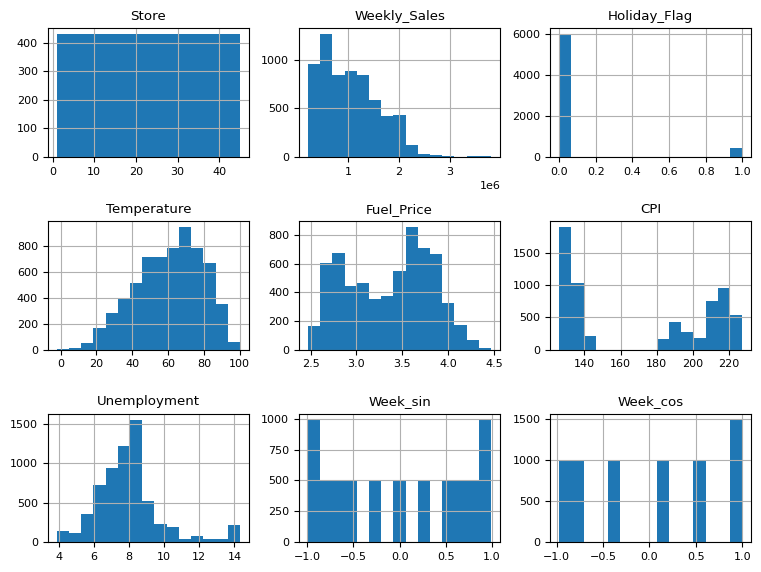

In [8]:
hist = features.hist(bins=15)
plt.rcParams.update({'font.size': 8})
plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.show()

Correlation

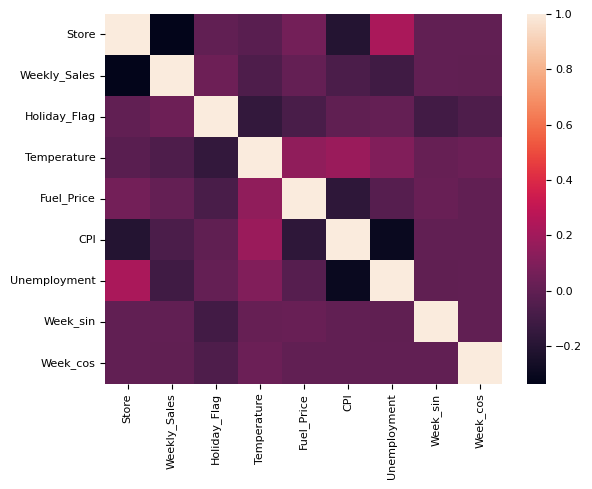

In [9]:
import seaborn as sns

correlation_mat = features.corr()
sns.heatmap(correlation_mat)
plt.show()

Plotting Cyclical Features

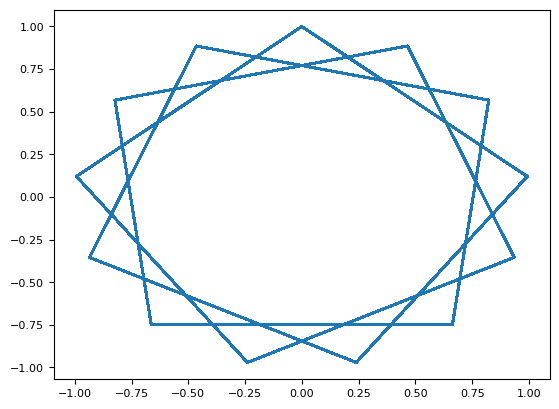

In [10]:
plt.plot(df['Week_sin'],df['Week_cos'])
plt.show()

### Pre-processing

In [11]:

test_df = df[(df['Date'] >= '04-06-2012')]
val_df = df[(df['Date'] < '20-07-2012') & (df['Date'] >= '23-12-2011')]
train_df = df[(df['Date'] < '04-06-2012')]

X_train = train_df.drop(['Date'], axis=1).to_numpy().reshape(45*113,9)
X_val = val_df.drop(['Date'], axis=1).to_numpy().reshape(45*30,9)
X_test = test_df.drop(['Date'], axis=1).to_numpy().reshape(45*30,9)
X_train.shape,X_val.shape,X_test.shape

((5085, 9), (1350, 9), (1350, 9))

In [12]:
#scale  data
sc = StandardScaler()
mm = MinMaxScaler()
X_train = X_train.reshape(45,113,9)
X_val = X_val.reshape(45,30,9)
X_test = X_test.reshape(45,30,9)

In [13]:
#create training windows
X_train_s = np.empty((0,15,9))
y_train_s = np.array([])
for i in range(len(X_train)):
  idx = 0
  while(len(X_train[i]) > idx+15):
    #use sliding windows of length 15 with step size of 1
    X_train_s = np.vstack((X_train_s, X_train[i][idx:idx+15].reshape(1,15,9)))
    y_train_s = np.append(y_train_s , X_train[i][idx+15][1])
    idx += 1
X_train_s = X_train_s.reshape(66150,9)
X_train = sc.fit_transform(X_train_s).reshape(4410,15,9)
y_train = mm.fit_transform(y_train_s.reshape(len(y_train_s),1))

X_train.shape,y_train.shape

((4410, 15, 9), (4410, 1))

In [14]:
#create validation windows
X_val_s = np.empty((0,15,9))
y_val_s = np.array([])
for i in range(len(X_val)):
  idx = 0
  while(len(X_val[i]) > idx+15):
    #use sliding windows of length 15 with step size of 1
    X_val_s = np.vstack((X_val_s, X_val[i][idx:idx+15].reshape(1,15,9)))
    y_val_s = np.append(y_val_s , X_val[i][idx+15][1])
    idx += 1
X_val_s = X_val_s.reshape(675*15,9)
X_val = sc.transform(X_val_s).reshape(675,15,9)
y_val = mm.transform(y_val_s.reshape(len(y_val_s),1))
X_val.shape,y_val.shape

((675, 15, 9), (675, 1))

In [15]:
#create test windows
X_test_s = np.empty((0,15,9))
y_test_s = np.array([])
for i in range(len(X_test)):
  idx = 0
  while(len(X_test[i]) > idx+15):
    #use sliding windows of length 15 with step size of 1
    X_test_s = np.vstack((X_test_s, X_test[i][idx:idx+15].reshape(1,15,9)))
    y_test_s = np.append(y_test_s , X_test[i][idx+15][1])
    idx += 1
X_test_s = X_test_s.reshape(675*15,9)
X_test = sc.transform(X_test_s).reshape(675,15,9)
y_test = mm.transform(y_test_s.reshape(len(y_test_s),1))
X_test.shape,y_test.shape

((675, 15, 9), (675, 1))

### General Setup


In [16]:
#Prepare data for training
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.reshape(len(y_train_s),1).astype(np.float32))
y_val = torch.from_numpy(y_val.reshape(len(y_val_s),1).astype(np.float32))
y_test = torch.from_numpy(y_test.reshape(len(y_test_s),1).astype(np.float32))

In [17]:
# Adapted from https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html
def training_loop(n_epochs, model, optimiser, loss_fn, X_train, y_train,
                  X_test=None, y_test=None):
    l = np.array([])
    for epoch in range(n_epochs):
        model.train()
        outputs = model.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        l = np.append(l,loss.detach().numpy()) #save training loss
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
    return l #return training loss





#### RNN Structure
I use a single RNN layer with two hidden units. I pass the resulting hidden state through a relu activation function and a linear layer.

Performance of each network is measured using Root Mean Squared Logarithmic Error (RMSLE).

### Vanilla RNN

In [21]:
#Adapted from https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html
class VanillaRNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each rnn layer
        self.rnn = nn.RNN(input_size, hidden_size,batch_first=True)
        self.fc =  nn.Linear(hidden_size, num_classes) # fully connected
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through RNN
        out, hn = self.rnn(x, h_0) # (input, hidden state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc(out)
        return out

In [22]:
X_train_t = Variable(torch.Tensor(X_train))
X_val_t = Variable(torch.Tensor(X_val))

y_train_t = Variable(y_train)
y_val_t = Variable(y_val)
n_epochs =  2000 #epochs
learning_rate =  0.005# lr

input_size = 9 # number of features
hidden_size = 2 # number of features in hidden state
num_classes = 1 # number of output classes

rnn = VanillaRNN(num_classes,
              input_size,
              hidden_size,
              num_classes)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
l=training_loop(n_epochs=n_epochs,
          model=rnn,
          optimiser=optimiser,
          loss_fn=loss_fn,
          X_train=X_train_t,
          y_train=y_train_t,
          X_test=X_val_t,
          y_test=y_val_t)

Loss Function

Text(0, 0.5, 'MSE Loss')

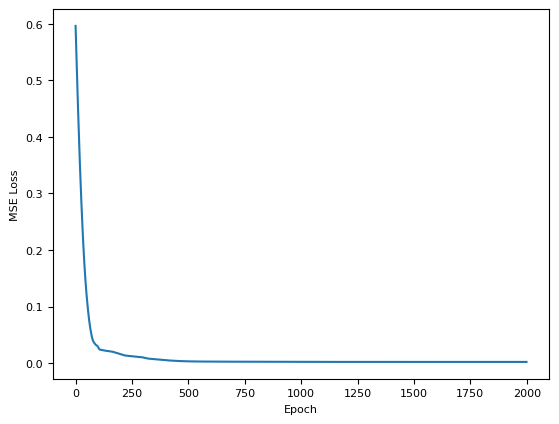

In [23]:
plt.plot(np.arange(0,len(l),1),l)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

#### RMSLE Loss

Validation Error

In [26]:
from sklearn.metrics import root_mean_squared_log_error
#predict validation set
y_pred = rnn(X_val).detach().numpy()
#unscale the data
y_pred_s = mm.inverse_transform(y_pred).reshape(45,15)
y_true_s = mm.inverse_transform(y_val).reshape(45,15)
msle = root_mean_squared_log_error(y_true_s, y_pred_s)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0746


Test Error

In [32]:
#predict test set
y_predt = rnn(X_test).detach().numpy()
#unscale the data
y_predt_s = mm.inverse_transform(y_predt).reshape(45,15)
y_test_s = mm.inverse_transform(y_test).reshape(45,15)
msle = root_mean_squared_log_error(y_test_s, y_predt_s)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0715


#### Sample Prediction

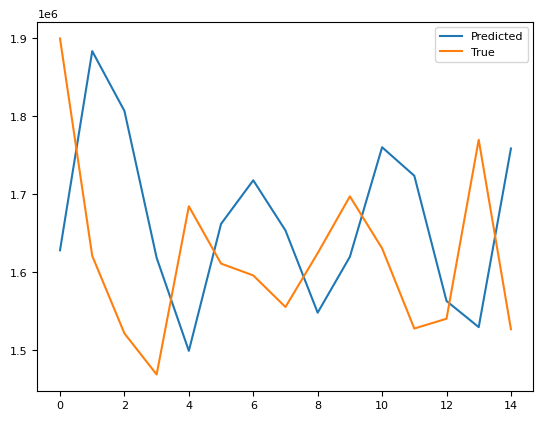

In [27]:
plt.plot(np.arange(0,len(y_pred_s[0]),1),y_pred_s[0], label='Predicted')
plt.plot(np.arange(0,len(y_true_s[0]),1),y_true_s[0], label='True')
plt.legend()
plt.show()

### LSTM

In [28]:
#Adapted from https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0) # lstm
        self.fc =  nn.Linear(hidden_size, num_classes) # fully connected
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc(out)
        return out


In [29]:
n_epochs =  2000 #epochs
learning_rate =  0.005# lr

input_size = 9 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 1 # number of output classes

lstm = LSTM(num_classes,input_size,hidden_size,num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
l = training_loop(n_epochs=n_epochs,
          model=lstm,
          optimiser=optimiser,
          loss_fn=loss_fn,
          X_train=X_train_t,
          y_train=y_train_t,
          X_test=X_val_t,
          y_test=y_val_t)

Loss Function

Text(0, 0.5, 'MSE Loss')

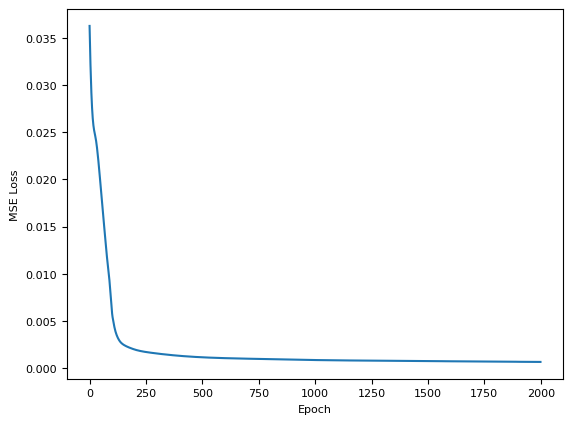

In [30]:
plt.plot(np.arange(0,len(l),1),l)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

Validation Error

In [31]:
#predict validation set
y_pred = lstm(X_val).detach().numpy()
#unscale the data
y_pred_s = mm.inverse_transform(y_pred).reshape(45,15)
msle = root_mean_squared_log_error(y_val, y_pred)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0187


Test Error

In [33]:
#predict test set
y_predt = lstm(X_test).detach().numpy()
#unscale the data
y_predt_s = mm.inverse_transform(y_predt).reshape(45,15)
msle = root_mean_squared_log_error(y_test_s, y_predt_s)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0742


Sample Prediction

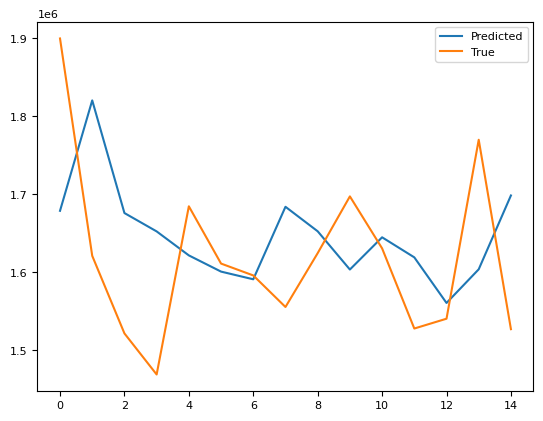

In [34]:
plt.plot(np.arange(0,len(y_pred_s[0]),1),y_pred_s[0], label='Predicted')
plt.plot(np.arange(0,len(y_true_s[0]),1),y_true_s[0], label='True')
plt.legend()
plt.show()

### GRU

In [37]:
#Adapted from https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each rnn layer
        self.gru = nn.GRU(input_size, hidden_size,batch_first=True)
        self.fc =  nn.Linear(hidden_size, num_classes) # fully connected
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through GRU
        out, hn = self.gru(x, h_0) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc(out)
        return out

In [38]:
n_epochs =  2000 #epochs
learning_rate =  0.005# lr

input_size = 9 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 1 # number of output classes

gru = GRU(num_classes,input_size,hidden_size,num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(gru.parameters(), lr=learning_rate)
l =training_loop(n_epochs=n_epochs,
          model=gru,
          optimiser=optimiser,
          loss_fn=loss_fn,
          X_train=X_train_t,
          y_train=y_train_t,
          X_test=X_val_t,
          y_test=y_val_t)

Loss Function

Text(0, 0.5, 'MSE Loss')

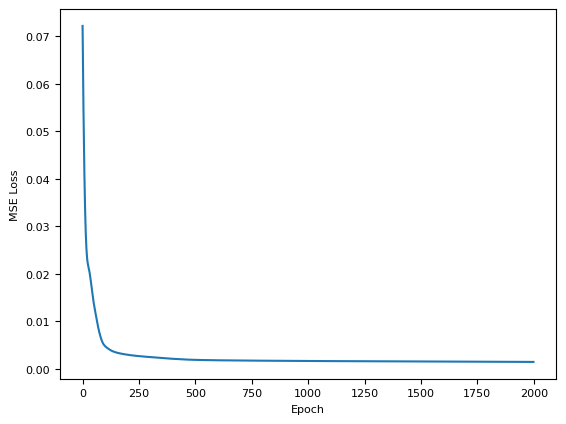

In [39]:
plt.plot(np.arange(0,len(l),1),l)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

Validation Error

In [40]:
#predict validation set
y_pred = gru(X_val).detach().numpy()
#unscale the data
y_pred_s = mm.inverse_transform(y_pred).reshape(45,15)
msle = root_mean_squared_log_error(y_val, y_pred)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0206


Test Error

In [41]:
#predict test set
y_predt = gru(X_test).detach().numpy()
#unscale the data
y_predt_s = mm.inverse_transform(y_predt).reshape(45,15)
msle = root_mean_squared_log_error(y_test_s, y_predt_s)
print(f'RMSLE: {msle:.4f}')

RMSLE: 0.0731


Sample Prediction

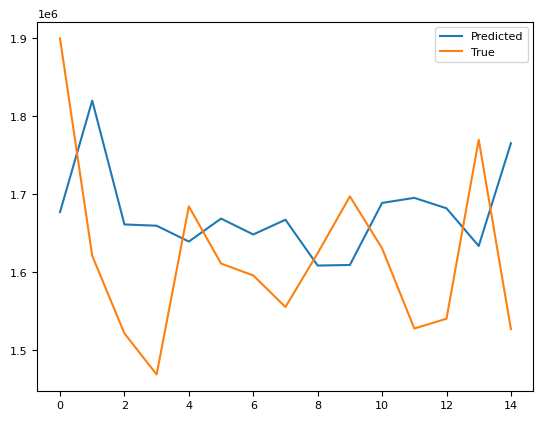

In [42]:
plt.plot(np.arange(0,len(y_pred_s[0]),1),y_pred_s[0], label='Predicted')
plt.plot(np.arange(0,len(y_true_s[0]),1),y_true_s[0], label='True')
plt.legend()
plt.show()

### Architecture Comparison

The performance of the different architectures varied in terms of training time. The vanilla RNN took 25 seconds to perform 2000 iterations, the LSTM took 2 minutes, and the GRU took 56 seconds. This is likely because the vanilla RNN is the most computationally simple model while the LSTM is the most complex. Despite the differences in training time, all models converged within approximately 150 iterations.

The vanilla RNN achieved a Root Mean Squared Logarithmic Error (RMSLE) of 0.0715 on the validation set and 0.0746 on the test set. The LSTM had an RMSLE of 0.0187 on the validation set and 0.0742 on the test set, while the GRU achieved an RMSLE of 0.0206 on the validation set and 0.0731 on the test set. Therefore, all models demonstrated comparable accuracy.

### Part 3
A traditional feed-forward network could be used. Values for n time steps could be included as features for each time step. For example, if we used 15 previous time steps and 9 features per time step there would be 15 * 9 + 9 features. Two drawbacks of this are that there would be a large number of features, and the network would not be able to capture the temporal structure that the RNNs do.

O'Neill, C. (2022, January 14). Multivariate time-series forecasting with Pytorch LSTMs. Charlie O'Neill. https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html

Zhang, A., Lipton, Z., Li, M., & Smola, A. (2023). Dive into Deep Learning. Cambridge University Press.
